In [1]:
import numpy as np
import sdeint
import gym
import numpy as np
from gym import spaces
import stable_baselines3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import A2C, PPO
import matplotlib.pyplot as plt


In [2]:
def abc_flow(y, t, *args):
    """
    abc flow with added control velocity
    
    args:
    y (np.array): np.array of length 3 specifying a particles current location
    t (list): list of floats with the time steps to solve for
    a,b,c (float): coeffcients or the abc flows
    control (array): float array of length 3 with the velocity components of the control term
    
    """
    control=args[0]
    a=args[1]
    b=args[2]
    c=args[3]
    
    X, Y, Z = y #/10
    #dydt = 10*np.array([a*np.sin(Z)+c*np.cos(Y)+control[0], b*np.sin(X)+a*np.cos(Z)+control[1], c*np.sin(Y)+b*np.cos(X)+control[2]])
    dydt = np.array([a*np.sin(Z)+c*np.cos(Y)+control[0], b*np.sin(X)+a*np.cos(Z)+control[1], c*np.sin(Y)+b*np.cos(X)+control[2]])
    return dydt



def brownian(x, t, *args):
    var = args[0]
    arr = np.eye(3) * var
    return arr

def closure(func, *args):
    def newfunc(x, t):
        return func(x, t, *args)
    return newfunc



"""
TODO

then test against og environment a bit

NOTE Need to find propper kappa noise value

"""


class ABCflow(gym.Env):
    
    def __init__(self,sep_size=0.2*np.pi, a=1.,b=.7,c=.43,seed=1,kappa=0.01579):
        super().__init__()
        self.sep_size=sep_size
        self.rng = np.random.default_rng(seed=seed)
        # uniform random generatio anywhere in a two pi periodic space
        self.passive = self.rng.random(3) * 2 * np.pi
        self.active = self.active_start_loc()
        self.reward=0
        self.deltaT=0.01
        self.time=0
        self.limit=10.
        self.kappa = kappa
        self.a=a
        self.b=b
        self.c=c
        self.action_space = spaces.Box(low=np.array([-5.0]), high=np.array([5.0]))
        self.observation_space = spaces.Box(low=np.array([-1.0,-1.0,-1.0]), high=np.array([1.0,1.0,1.0]))
        
        
        
    def reset(self):
        self.passive = self.rng.random(3) - 0.5
        self.active = self.active_start_loc()
        self.reward=0
        self.time=0
        info={}
        #print(self.getState().shape)
        return self.getState()#, info

    
    def step(self,phi_action):
        action=phi_action * self.getState()
        self.passive = sdeint.itoint(closure(abc_flow,np.zeros(3),self.a,self.b,self.c),
                                     closure(brownian, self.kappa*self.deltaT),
                                     self.passive,
                                     [self.time,self.time+self.deltaT])[-1]
        
        self.active = sdeint.itoint(closure(abc_flow,action,self.a,self.b,self.c),
                                     closure(brownian, self.kappa*self.deltaT),
                                     self.active,
                                     [self.time,self.time+self.deltaT])[-1]

        self.time+=self.deltaT
        self.reward=-(self.dist()**2+action@action)*self.deltaT
        
        info={}
        
        return self.getState(), self.reward, self.isOver(), {}
    
    #state is just the seperation vector
    def getState(self):
        return np.array(self.passive-self.active,np.float32)
    
    def isOver(self):
        return self.time >= self.limit
        
    def dist(self):
        seperation=self.passive-self.active
        return np.sqrt(seperation @ seperation)
   
    def active_start_loc(self):
        sep_vec = self.rng.random(3) - 0.5
        sep_vec = sep_vec*self.sep_size/np.linalg.norm(sep_vec)
        return self.passive + sep_vec


In [3]:
env = ABCflow()
check_env(env)

/home/cfckoh/anaconda3/envs/stableBase3/lib/python3.11/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/cfckoh/anaconda3/envs/stableBase3/lib/python3.11/site-packages/stable_baselines3/common/env_checker.py:361: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [4]:
eps=250
env = ABCflow()
env.deltaT= 0.05
env.limit=10.
time_steps = int(env.limit/env.deltaT)*250

model = A2C('MlpPolicy', env, verbose=True)
model.learn(total_timesteps=time_steps)
model.save("saved_models/A2C")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 200      |
|    ep_rew_mean        | -5.79    |
| time/                 |          |
|    fps                | 594      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.38    |
|    explained_variance | -42.6    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.00187 |
|    std                | 0.963    |
|    value_loss         | 0.000159 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 200      |
|    ep_rew_mean        | -2.81    |
| time/                 |          |
|    fps                | 605      |
|    iterations   

/home/cfckoh/anaconda3/envs/stableBase3/lib/python3.11/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/cfckoh/anaconda3/envs/stableBase3/lib/python3.11/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/cfckoh/anaconda3/envs/stableBase3/lib/python3.11/site-packages/stable_baselines3/common/utils.py:64: RuntimeWarning: invalid value encountered in scalar divide
  return np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y


-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 200       |
|    ep_rew_mean        | -6e+21    |
| time/                 |           |
|    fps                | 607       |
|    iterations         | 400       |
|    time_elapsed       | 3         |
|    total_timesteps    | 2000      |
| train/                |           |
|    entropy_loss       | -1.37     |
|    explained_variance | nan       |
|    learning_rate      | 0.0007    |
|    n_updates          | 399       |
|    policy_loss        | -8.49e+20 |
|    std                | 0.948     |
|    value_loss         | inf       |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 200      |
|    ep_rew_mean        | -5e+21   |
| time/                 |          |
|    fps                | 612      |
|    iterations         | 500      |
|    time_elapsed       | 4        |
|    total_timesteps

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 200       |
|    ep_rew_mean        | -1.43e+21 |
| time/                 |           |
|    fps                | 633       |
|    iterations         | 1700      |
|    time_elapsed       | 13        |
|    total_timesteps    | 8500      |
| train/                |           |
|    entropy_loss       | -1.28     |
|    explained_variance | -3.48     |
|    learning_rate      | 0.0007    |
|    n_updates          | 1699      |
|    policy_loss        | -0.797    |
|    std                | 0.868     |
|    value_loss         | 0.963     |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 200       |
|    ep_rew_mean        | -1.33e+21 |
| time/                 |           |
|    fps                | 633       |
|    iterations         | 1800      |
|    time_elapsed       | 14        |
|    total_t

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 200       |
|    ep_rew_mean        | -2.19e+25 |
| time/                 |           |
|    fps                | 628       |
|    iterations         | 2900      |
|    time_elapsed       | 23        |
|    total_timesteps    | 14500     |
| train/                |           |
|    entropy_loss       | -1.28     |
|    explained_variance | -2.56     |
|    learning_rate      | 0.0007    |
|    n_updates          | 2899      |
|    policy_loss        | -0.267    |
|    std                | 0.87      |
|    value_loss         | 0.0686    |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 200       |
|    ep_rew_mean        | -2.1e+25  |
| time/                 |           |
|    fps                | 627       |
|    iterations         | 3000      |
|    time_elapsed       | 23        |
|    total_t

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 200       |
|    ep_rew_mean        | -1.58e+25 |
| time/                 |           |
|    fps                | 619       |
|    iterations         | 4100      |
|    time_elapsed       | 33        |
|    total_timesteps    | 20500     |
| train/                |           |
|    entropy_loss       | -1.25     |
|    explained_variance | -21.9     |
|    learning_rate      | 0.0007    |
|    n_updates          | 4099      |
|    policy_loss        | -0.149    |
|    std                | 0.846     |
|    value_loss         | 0.0683    |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 200       |
|    ep_rew_mean        | -1.58e+25 |
| time/                 |           |
|    fps                | 619       |
|    iterations         | 4200      |
|    time_elapsed       | 33        |
|    total_t

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 200       |
|    ep_rew_mean        | -1.58e+25 |
| time/                 |           |
|    fps                | 618       |
|    iterations         | 5300      |
|    time_elapsed       | 42        |
|    total_timesteps    | 26500     |
| train/                |           |
|    entropy_loss       | -1.2      |
|    explained_variance | 0.874     |
|    learning_rate      | 0.0007    |
|    n_updates          | 5299      |
|    policy_loss        | 0.00766   |
|    std                | 0.806     |
|    value_loss         | 8.88e-05  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 200       |
|    ep_rew_mean        | -1.58e+25 |
| time/                 |           |
|    fps                | 618       |
|    iterations         | 5400      |
|    time_elapsed       | 43        |
|    total_t

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 200       |
|    ep_rew_mean        | -8.04e+09 |
| time/                 |           |
|    fps                | 617       |
|    iterations         | 6500      |
|    time_elapsed       | 52        |
|    total_timesteps    | 32500     |
| train/                |           |
|    entropy_loss       | -1.15     |
|    explained_variance | 0.0113    |
|    learning_rate      | 0.0007    |
|    n_updates          | 6499      |
|    policy_loss        | -0.00594  |
|    std                | 0.764     |
|    value_loss         | 3.64e-05  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 200       |
|    ep_rew_mean        | -8.04e+09 |
| time/                 |           |
|    fps                | 617       |
|    iterations         | 6600      |
|    time_elapsed       | 53        |
|    total_t

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 200       |
|    ep_rew_mean        | -1.15e+07 |
| time/                 |           |
|    fps                | 616       |
|    iterations         | 7700      |
|    time_elapsed       | 62        |
|    total_timesteps    | 38500     |
| train/                |           |
|    entropy_loss       | -1.11     |
|    explained_variance | -2.1      |
|    learning_rate      | 0.0007    |
|    n_updates          | 7699      |
|    policy_loss        | -0.00826  |
|    std                | 0.733     |
|    value_loss         | 5.91e-05  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 200       |
|    ep_rew_mean        | -1.13e+07 |
| time/                 |           |
|    fps                | 615       |
|    iterations         | 7800      |
|    time_elapsed       | 63        |
|    total_t

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 200       |
|    ep_rew_mean        | -5.75e+05 |
| time/                 |           |
|    fps                | 613       |
|    iterations         | 8900      |
|    time_elapsed       | 72        |
|    total_timesteps    | 44500     |
| train/                |           |
|    entropy_loss       | -1.06     |
|    explained_variance | 0.598     |
|    learning_rate      | 0.0007    |
|    n_updates          | 8899      |
|    policy_loss        | 0.0034    |
|    std                | 0.696     |
|    value_loss         | 1e-05     |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 200      |
|    ep_rew_mean        | -1.07    |
| time/                 |          |
|    fps                | 613      |
|    iterations         | 9000     |
|    time_elapsed       | 73       |
|    total_timesteps

In [8]:
model2 = PPO('MlpPolicy', env, verbose=True)
model2.load("saved_models/A2C")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


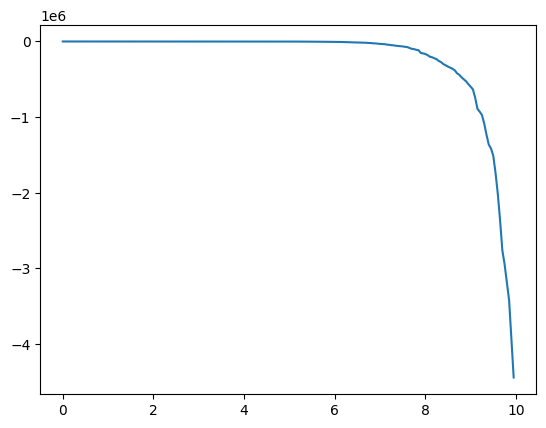

In [9]:
num_eps=1
cum_rew=np.zeros(int(env.limit/env.deltaT))
for ep in range(2):
    obs = env.reset()
    done = False
    time_step=0
    episode_rew=0
    while not done:
        action, _states = model.predict(obs)
        #print(action)
        obs, reward, done, info = env.step(action)
        episode_rew += reward
        cum_rew[time_step] += episode_rew
        time_step+=1
plt.plot(np.arange(len(cum_rew))/(1/env.deltaT),cum_rew/num_eps)

In [7]:
cum_rew

array([-5.12172418e-02, -1.36697770e-01, -1.87043928e-01, -2.58132924e-01,
       -3.16623514e-01, -4.26557117e-01, -5.09092886e-01, -6.08840513e-01,
       -7.22888454e-01, -8.10801784e-01, -9.11930798e-01, -1.00676155e+00,
       -1.11256253e+00, -1.27131533e+00, -1.46329052e+00, -1.63510555e+00,
       -1.90214665e+00, -2.06725748e+00, -2.24109473e+00, -2.50543740e+00,
       -2.72794772e+00, -3.09826315e+00, -3.53898049e+00, -4.02942319e+00,
       -4.64559490e+00, -5.00013285e+00, -5.67213355e+00, -6.10560292e+00,
       -6.49737137e+00, -6.85308390e+00, -7.23200126e+00, -7.62163741e+00,
       -8.12627113e+00, -8.46487783e+00, -9.02519023e+00, -9.44757068e+00,
       -1.01845186e+01, -1.06088219e+01, -1.12302646e+01, -1.19582822e+01,
       -1.24686097e+01, -1.29420489e+01, -1.33935979e+01, -1.41367815e+01,
       -1.45508377e+01, -1.54316784e+01, -1.59002201e+01, -1.65237107e+01,
       -1.69459511e+01, -1.72890607e+01, -1.76486337e+01, -1.81147539e+01,
       -1.84677258e+01, -